In [1]:
%matplotlib inline

In [2]:
from KnackpackData import getEncoded,getScores,scoreFunction,n_items
import matplotlib.pyplot as plt
import numpy as np
import random
np.random.seed(seed=42)
random.seed(a=42)

## Initial population takes 20% of items

In [3]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.8*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return np.array(population)

## Fitness score by value of backpack

In [4]:
from numba import njit

@njit("float64[::1](boolean[:,::1],float64[::1],float64[::1],float64)")
def fitness_score(population,values,weights,max_weight_loc):
    return np.array([-1 if np.sum(weights[gene]) > max_weight_loc else np.sum(values[gene]) for gene in population])


## Roulette wheel selection

In [5]:
def selection(scores,population_nextgen,k,population_size):
    return random.choices(population_nextgen, weights = scores, k=population_size)

## Single point crossover

In [6]:
def crossover(pop_after_sel,crossover_rate):
    def crossingMethod(index):
        point = random.randint(0, len(pop_after_sel[0]))
        next_index = (index+1)%len(pop_after_sel)
        return np.concatenate((pop_after_sel[index][:point],pop_after_sel[next_index][point:]))
    childrens = np.array([crossingMethod(index) for index in range(len(pop_after_sel)) if random.random() < crossover_rate])
    return np.concatenate((pop_after_sel,childrens))

## Bit flip mutation

In [7]:
@njit("boolean[:,::1](boolean[:,::1],float64)")
def mutation(pop_after_cross,mutation_rate):
    size = pop_after_cross.shape[0]
    randoms = np.random.rand(size)
    unit_size = pop_after_cross.shape[1]
    for i in range(size):
        if(randoms[i]<mutation_rate):
            j = np.random.randint(0, unit_size)
            pop_after_cross[i][j]^=pop_after_cross[i][j]
    return pop_after_cross

## Generation loop with stop conditions:

* no change of best score through *max_stale_iterations*

*  90% of the population fall within convergence of the fittest individual

In [8]:
from math import isclose
def generations(values,weights,max_weight,population_size,n_feat,crossover_rate,mutation_rate,k_tournament,max_iteration,max_stale_iterations):
    def pupulation_in_convergence(scores,iteration_best_score):
        return sum(isclose(iteration_best_score,score) for score in scores)/scores.size>0.9
    alltime_best_score = 0
    stale_iteration = 0
    stop_reason = "Reached max_iteration!"
    # fittest does not change
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(population_size,n_feat)
    for i in range(max_iteration):
        scores = fitness_score(population_nextgen,values,weights,max_weight)

        bestIndex = np.argmax(scores)
        best_chromo.append(population_nextgen[bestIndex])
        best_score.append(scores[bestIndex])
        
        pop_after_sel = selection(scores,population_nextgen,k_tournament,population_size)
        pop_after_cross = crossover(pop_after_sel,crossover_rate)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        
        if alltime_best_score >= scores[bestIndex]:
            stale_iteration+=1
        else :
            stale_iteration=0
            alltime_best_score = scores[bestIndex]
        
        if stale_iteration>=max_stale_iterations:
            stop_reason = "Reached max_stale_iterations!"
            break
        if pupulation_in_convergence(scores,scores[bestIndex]):
            stop_reason = "Pupulation converge in 90%!"
            break
      
    return best_chromo,best_score,stop_reason

## Visualization methods

In [9]:
from operator import itemgetter
def plotScore(scores,bestindex):
    plt.figure(figsize=(8, 6), dpi=80) 
    plt.plot(scores)
    plt.scatter(bestindex, scores[bestindex],color="g",s=50)
    plt.annotate("best", (bestindex,scores[bestindex]))
    plt.ylabel('scores')
    plt.show()
    
def getBest(chromosomes,scores):
    best = max(zip(chromosomes,scores), key=itemgetter(1))
    bestindex = scores.index(best[1])
    return best,bestindex

In [10]:
from pandas import DataFrame, read_csv

max_weight = 3.0

correlation_levels = ["no", "low", "high"]
item_counts = list(range(16,25))
                  
results = np.zeros((len(item_counts), len(correlation_levels)))

for i, level in enumerate(correlation_levels):
    for j, item_count in enumerate(item_counts):
        csv = read_csv(f"Data//{level}_correlation_{item_count}")
        n_items = csv.shape[0]
        values = csv.value.values
        weights = csv.weight.values

        chromo,score,stop_reason=generations(values,weights,max_weight,population_size=100,n_feat=n_items,crossover_rate=0.1,mutation_rate=0.3,k_tournament=0,max_iteration=100,max_stale_iterations=30)
        best,bestindex = getBest(chromo,score)

        results[j,i] = score[bestindex]
        print(f"Tests finished: {i*len(item_counts)+j+1}/{len(item_counts)*len(correlation_levels)}", end="\r")
        

In [11]:
df_res = DataFrame(data=results, columns=correlation_levels, index=item_counts)
df_res

,no,low,high
16,2.901931,3.840650,3.861181
17,3.698705,3.877263,4.447591
18,5.348981,5.995194,5.467431
19,4.361052,4.815755,4.282067
20,4.026004,3.543675,4.592085
21,6.033231,5.825849,5.390671
22,5.194917,5.222975,4.911434
23,6.821555,5.351203,5.128609
24,5.237358,5.106838,4.511915


<AxesSubplot:title={'center':'Result for correlated data'}, xlabel='Items', ylabel='Value'>

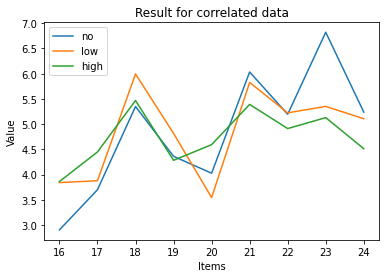

In [12]:
df_res.plot(title="Result for correlated data", xlabel="Items", ylabel="Value")

In [13]:
df_res.to_csv("Results//GA.csv")

## K-Tournament Selection(20)

In [14]:
def selection(scores,population_nextgen,k,population_size):
    def tournament_selection(indices):
        return population_nextgen[max(indices,key=lambda index:scores[index])]
    return np.array([tournament_selection(random.choices(range(scores.size),k = k)) for _ in range(population_size)])

## Two point mutation

In [15]:
@njit("boolean[:,::1](boolean[:,::1],float64)")
def mutation(pop_after_cross,mutation_rate):
    size = pop_after_cross.shape[0]
    randoms = np.random.rand(size)
    unit_size = pop_after_cross.shape[1]
    for i in range(size):
        if(randoms[i]<mutation_rate):
            j = np.random.randint(0, unit_size)
            k = np.random.randint(0, unit_size)
            pop_after_cross[i][j]^=pop_after_cross[i][j]
            pop_after_cross[i][k]^=pop_after_cross[i][k]
    return pop_after_cross

## To use with SIMULATED ANNEALING ALGORITHM

In [16]:
from math import isclose
from simulatedAnnealing import simulatedAnnealing
def generations(values,weights,max_weight,population_size,n_feat,crossover_rate,mutation_rate,k_tournament,max_iteration,max_stale_iterations):
    def pupulation_in_convergence(scores,iteration_best_score):
        return sum(isclose(iteration_best_score,score) for score in scores)/scores.size>0.9
    alltime_best_score = 0
    stale_iteration = 0
    stop_reason = "Reached max_iteration!"
    # fittest does not change
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(population_size,n_feat)
    for i in range(max_iteration):
        scores = fitness_score(population_nextgen,values,weights,max_weight)
        bestIndex = np.argmax(scores)
        
        _,best = simulatedAnnealing(2100, 0.96, 0.0001, n_feat, values, weights, max_weight, starting_state = population_nextgen[bestIndex])
        population_nextgen[bestIndex] = best

        scores = fitness_score(population_nextgen,values,weights,max_weight)
        bestIndex = np.argmax(scores)

        best_chromo.append(population_nextgen[bestIndex])
        best_score.append(scores[bestIndex])
        
        pop_after_sel = selection(scores,population_nextgen,k_tournament,population_size)
        pop_after_cross = crossover(pop_after_sel,crossover_rate)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        
        if alltime_best_score >= scores[bestIndex]:
            stale_iteration+=1
        else :
            stale_iteration=0
            alltime_best_score = scores[bestIndex]
        
        if stale_iteration>=max_stale_iterations:
            stop_reason = "Reached max_stale_iterations!"
            break
        if pupulation_in_convergence(scores,scores[bestIndex]):
            stop_reason = "Pupulation converge in 90%!"
            break
  
    return best_chromo,best_score,stop_reason

Pupulation converge in 90%!


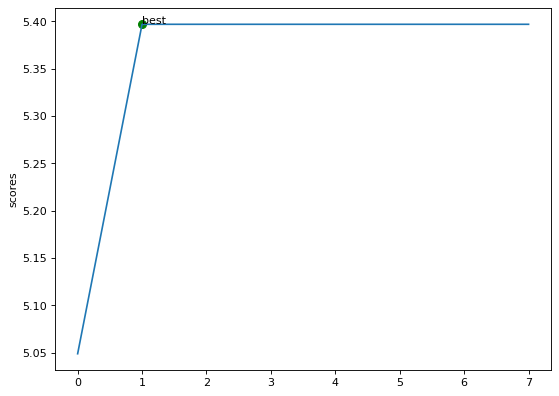

Final value[ True False  True False  True  True False  True False False  True False
 False False False  True False False  True False False False False False]=2.5034396648406982


In [17]:
chromo,score,stop_reason=generations(values,weights,max_weight,population_size=100,n_feat=n_items,crossover_rate=0.8,mutation_rate=0.2,k_tournament=20,max_iteration=100,max_stale_iterations=7)
print(stop_reason)
best,bestindex = getBest(chromo,score)
plotScore(score,bestindex)
x = best[0]
y = scoreFunction(best[0])
print(f"Final value{x}={y}")

In [18]:
# from pandas import DataFrame, read_csv

max_weight = 3.0

correlation_levels = ["no", "low", "high"]
item_counts = list(range(16,25))
                  
results = np.zeros((len(item_counts), len(correlation_levels)))

for i, level in enumerate(correlation_levels):
    for j, item_count in enumerate(item_counts):
        csv = read_csv(f"Data//{level}_correlation_{item_count}")
        n_items = csv.shape[0]
        values = csv.value.values
        weights = csv.weight.values

        chromo,score,stop_reason=generations(values,weights,max_weight,population_size=100,n_feat=n_items,crossover_rate=0.8,mutation_rate=0.2,k_tournament=20,max_iteration=100,max_stale_iterations=7)
        best,bestindex = getBest(chromo,score)

        results[j,i] = score[bestindex]
        print(f"Tests finished: {i*len(item_counts)+j+1}/{len(item_counts)*len(correlation_levels)}", end="\r")
        

In [19]:
df_res = DataFrame(data=results, columns=correlation_levels, index=item_counts)
df_res

,no,low,high
16,4.125811,3.837242,4.934728
17,4.525494,4.879110,4.960102
18,6.789740,7.061440,7.004848
19,4.715817,5.347431,5.426557
20,4.395976,5.126956,4.964960
21,6.219081,6.072498,5.922402
22,5.675517,5.694195,5.155062
23,7.465483,6.641442,6.216600
24,5.637281,5.847261,5.470162


<AxesSubplot:title={'center':'Result for correlated data'}, xlabel='Items', ylabel='Value'>

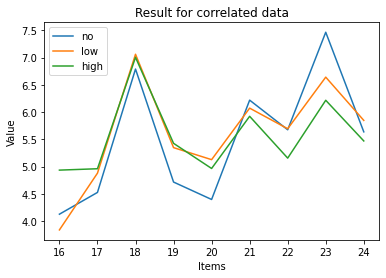

In [20]:
df_res.plot(title="Result for correlated data", xlabel="Items", ylabel="Value")

In [21]:
df_res.to_csv("Results//SAGA.csv")

## Wynik 
Wynik to maksimum globalne